In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.metrics import f1_score, classification_report
from matplotlib import pyplot as plt
import matplotlib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import StandardScaler

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 14})

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

In [5]:
data = pd.read_csv(TRAIN_DATASET_PATH)
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
def show_hist(data_: pd.DataFrame) -> None:
    fig, ax = plt.subplots(nrows=4, ncols=3)

    fig.set_size_inches(25, 15)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    for ax_i, column_i in zip(ax.flatten(), data_.columns):
        getattr(ax_i, 'hist')(data_[column_i])
        getattr(ax_i, 'set_title')(column_i)

    plt.show()

In [7]:
def fill_gaps(data_: pd.DataFrame) -> None:
    for column_ in data_.select_dtypes(exclude='object').columns:
        data_[column_].fillna(data_[column_].median(), inplace=True)
    for column_ in data_.select_dtypes(include='object').columns:
        data_[column_].fillna(data_[column_].mode()[0], inplace=True)

In [8]:
def fix_outlet(data_: pd.DataFrame) -> None:
    for column_ in data_.select_dtypes(exclude='object').columns:
        q1 = np.percentile(data_[column_], 25, interpolation='midpoint')
        q3 = np.percentile(data_[column_], 75, interpolation='midpoint')
        data.loc[(data_[column_] < q1) | (data_[column_] > q3), column_] = data[column_].median()

In [9]:
def drop_gaps(data_: pd.DataFrame) -> pd.DataFrame:
    return data_.dropna()

In [10]:
def density_plot(data_: pd.DataFrame) -> None:
    plt.figure(figsize=(100, 150))
    features = data_.select_dtypes(exclude='object').columns
    gs = gridspec.GridSpec(len(features), 1)
    for i, feature in enumerate(data_[features]):
        ax = plt.subplot(gs[i])
        sns.distplot(data_[feature][data_['Credit Default'] == 1], bins=50)
        sns.distplot(data_[feature][data_['Credit Default'] == 0], bins=50)
        ax.set_xlabel('')
        ax.set_title('Feature: ' + str(feature))
    plt.show()

In [11]:
fill_gaps(data)

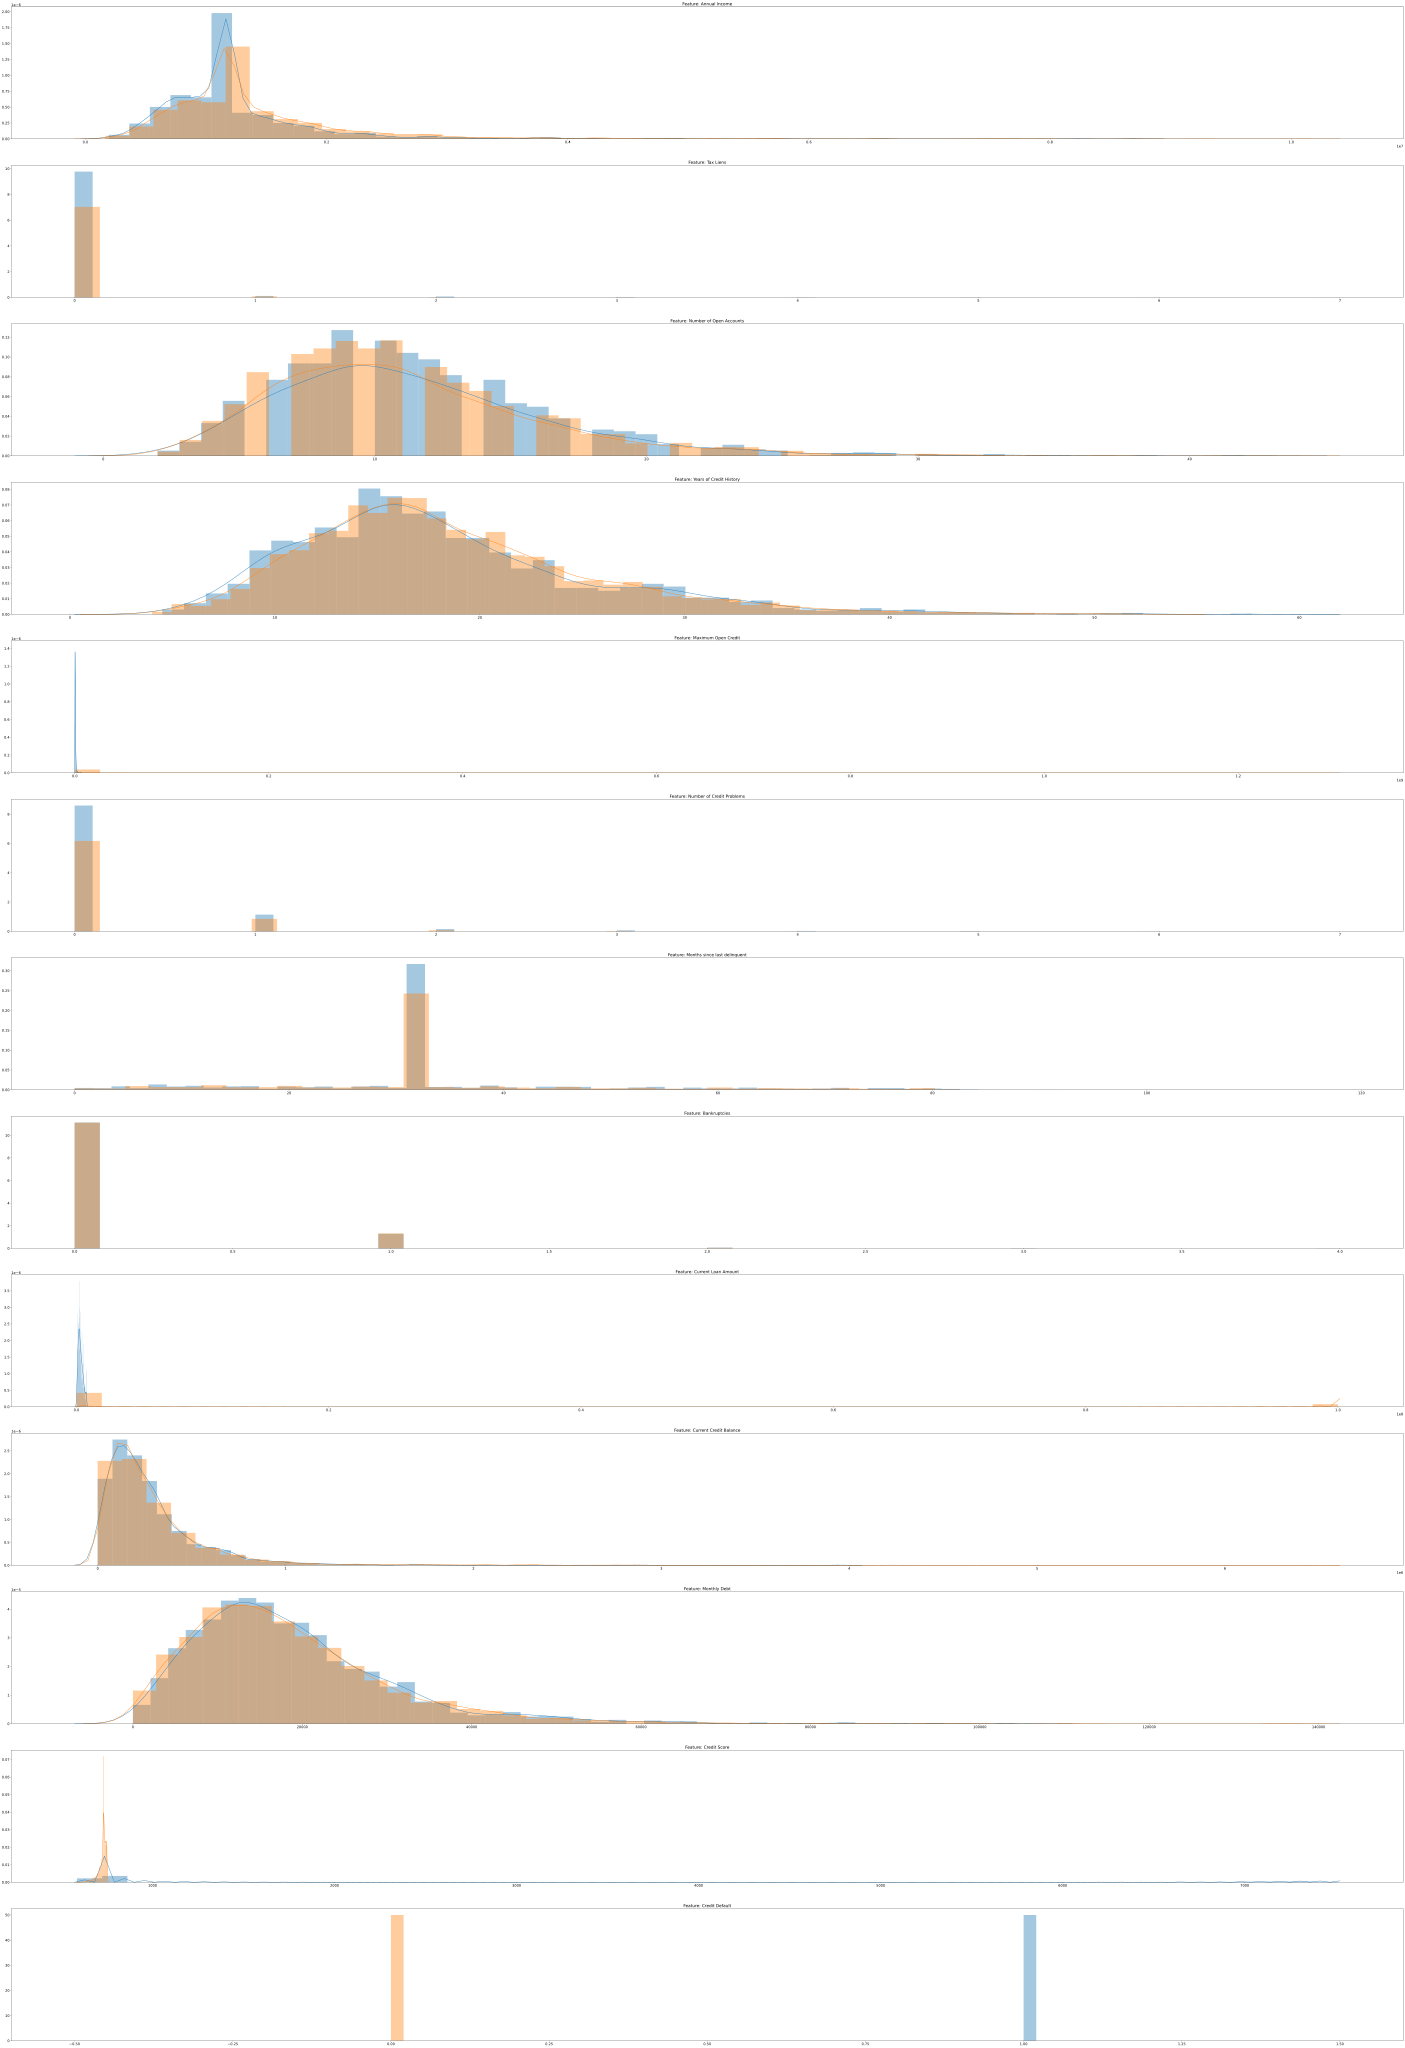

In [12]:
density_plot(data)

In [13]:
data = data.drop(columns=['Years of Credit History', 'Monthly Debt'])

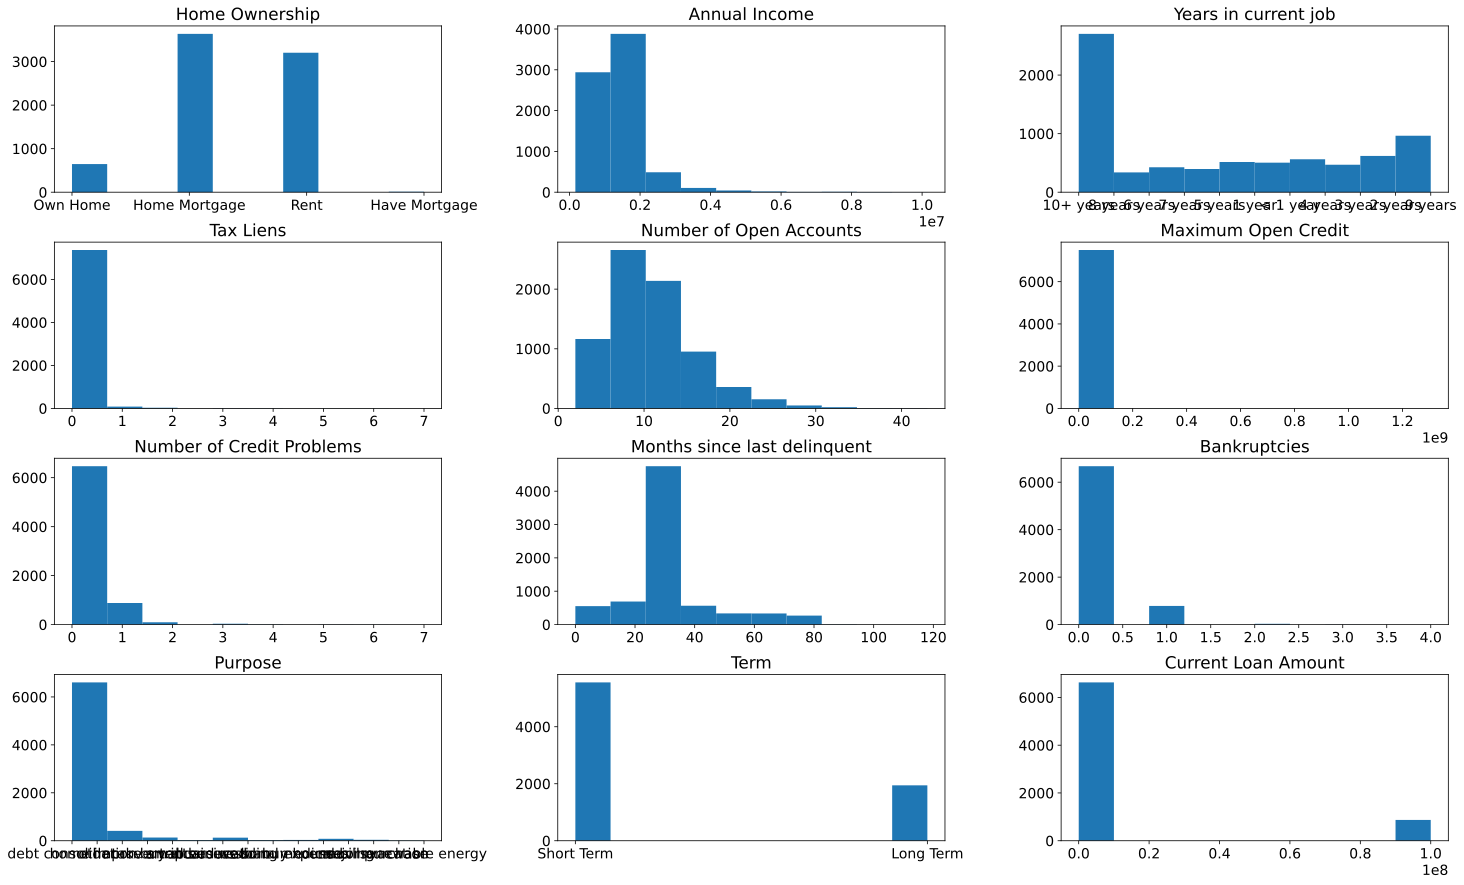

In [14]:
show_hist(data)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Maximum Open Credit           7500 non-null   float64
 6   Number of Credit Problems     7500 non-null   float64
 7   Months since last delinquent  7500 non-null   float64
 8   Bankruptcies                  7500 non-null   float64
 9   Purpose                       7500 non-null   object 
 10  Term                          7500 non-null   object 
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Cre

In [16]:
for cat_colname in data.select_dtypes(include='object').columns:
    print(f'{cat_colname}\n\n{data[cat_colname].value_counts()}\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [17]:
data['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [18]:
len(data) - data.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Credit Score                    0
Credit Default                  0
dtype: int64

In [19]:
data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000
mean,1.325286e+06,0.030133,11.130933,9.451537e+05,0.170000,33.227467,0.116933,1.187318e+07,2.898332e+05,1063.877333,0.281733
std,7.567551e+05,0.271604,4.908924,1.602622e+07,0.498598,14.703950,0.346904,3.192612e+07,3.178714e+05,1438.335832,0.449874
min,1.645970e+05,0.000000,2.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,585.000000,0.000000
25%,9.311330e+05,0.000000,8.000000,2.792295e+05,0.000000,32.000000,0.000000,1.801690e+05,1.142565e+05,718.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,731.000000,0.000000
75%,1.499974e+06,0.000000,14.000000,7.935015e+05,0.000000,32.000000,0.000000,5.198820e+05,3.604062e+05,740.000000,1.000000
max,1.014934e+07,7.000000,43.000000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,7510.000000,1.000000


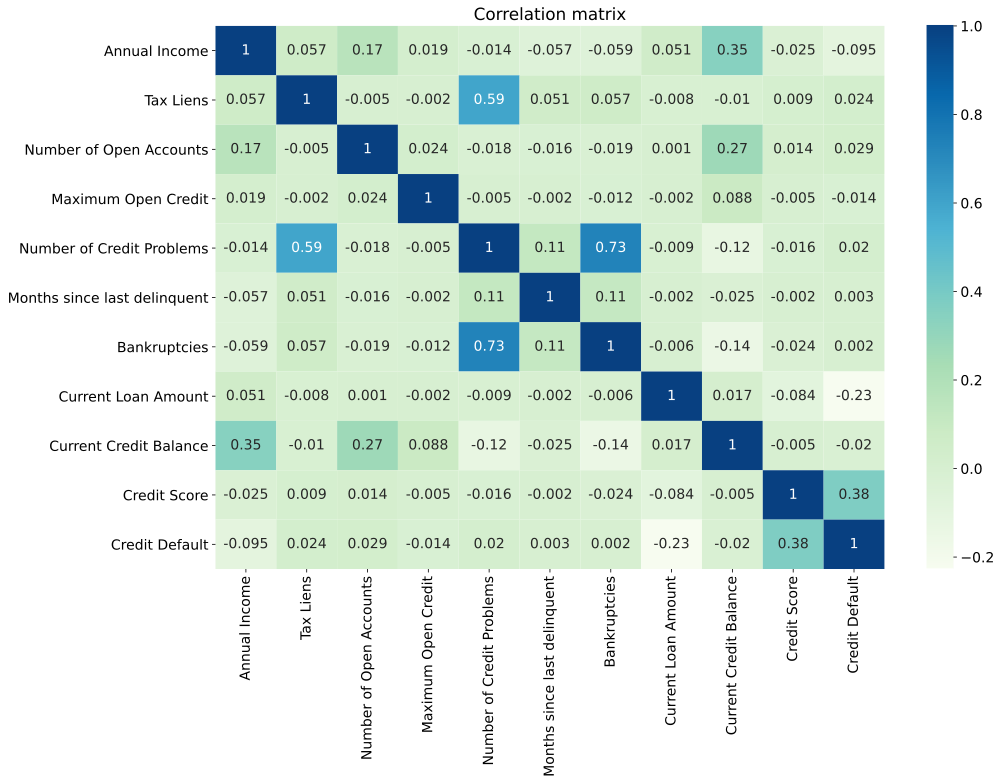

In [20]:
plt.figure(figsize=(15, 10))

sns.heatmap(data.corr().round(3), annot=True, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [21]:
from typing import List


def prepare_feature_name(data_: pd.DataFrame) -> None:
    new_columns = []  # type: List[str]
    for column in data_.columns:
        if " " in column:
            new_columns.append(column.replace(" ", ""))
            continue
        if "<" in column:
            new_columns.append(column.replace("<", "less"))
            continue
        new_columns.append(column)
    data_.columns = new_columns


In [22]:
data = pd.get_dummies(data)
prepare_feature_name(data)

X = data.drop(columns='CreditDefault')
y = data['CreditDefault']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
scaler = StandardScaler()

X_scaler_train = scaler.fit_transform(X_train)
X_scaler_test = scaler.transform(X_test)

In [24]:
X.head()

,AnnualIncome,TaxLiens,NumberofOpenAccounts,MaximumOpenCredit,NumberofCreditProblems,Monthssincelastdelinquent,Bankruptcies,CurrentLoanAmount,CurrentCreditBalance,CreditScore,...,Purpose_medicalbills,Purpose_moving,Purpose_other,Purpose_renewableenergy,Purpose_smallbusiness,Purpose_takeatrip,Purpose_vacation,Purpose_wedding,Term_LongTerm,Term_ShortTerm
0,482087.0,0.0,11.0,685960.0,1.0,32.0,1.0,99999999.0,47386.0,749.0,...,0,0,0,0,0,0,0,0,0,1
1,1025487.0,0.0,15.0,1181730.0,0.0,32.0,0.0,264968.0,394972.0,737.0,...,0,0,0,0,0,0,0,0,1,0
2,751412.0,0.0,11.0,1182434.0,0.0,32.0,0.0,99999999.0,308389.0,742.0,...,0,0,0,0,0,0,0,0,0,1
3,805068.0,0.0,8.0,147400.0,1.0,32.0,1.0,121396.0,95855.0,694.0,...,0,0,0,0,0,0,0,0,0,1
4,776264.0,0.0,13.0,385836.0,1.0,32.0,0.0,125840.0,93309.0,719.0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
model = XGBClassifier()
model.fit(X_scaler_train, y_train)

[11:51:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
y_pred = model.predict(X_scaler_test)
f1_score(y_test, y_pred)

0.486796785304248

In [27]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.78      0.93      0.84      1313
           1       0.69      0.38      0.49       562

    accuracy                           0.76      1875
   macro avg       0.73      0.65      0.67      1875
weighted avg       0.75      0.76      0.74      1875



Этап балансировки данных. Проба Oversampling

In [28]:
oversample = SMOTE()

X_over, y_over = oversample.fit_resample(X, y)

X_over.describe()

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.25, random_state=42)

model = XGBClassifier()
model.fit(X_scaler_train, y_train)

XGBoostError: [11:51:57] /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/data/data.cc:556: Check failed: labels_.Size() == num_row_ (8080 vs. 5625) : Size of labels must equal to number of rows.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000113eab0fe dmlc::LogMessageFatal::~LogMessageFatal() + 110
  [bt] (1) 2   libxgboost.dylib                    0x0000000113efe55c xgboost::MetaInfo::Validate(int) const + 1164
  [bt] (2) 3   libxgboost.dylib                    0x0000000113f650ca xgboost::LearnerImpl::ValidateDMatrix(xgboost::DMatrix*, bool) const + 58
  [bt] (3) 4   libxgboost.dylib                    0x0000000113f54c01 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 273
  [bt] (4) 5   libxgboost.dylib                    0x0000000113ea109c XGBoosterUpdateOneIter + 156
  [bt] (5) 6   libffi.7.dylib                      0x00000001027e7ead ffi_call_unix64 + 85
  [bt] (6) 7   ???                                 0x00007ffeedff0960 0x0 + 140732891335008

